In [2]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, log_loss, 
                             matthews_corrcoef, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import time

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


# Read Dataset

In [5]:
data = pd.read_csv(r'telecom_data.csv')

data.drop(['CustomerID'], axis = 1, inplace = True)

# Label Encoding

In [8]:
le = LabelEncoder()

data['SubscriptionType'] = le.fit_transform(data['SubscriptionType'])
data['PaymentMethod'] = le.fit_transform(data['PaymentMethod'])
data['PaperlessBilling'] = le.fit_transform(data['PaperlessBilling'])
data['ContentType'] = le.fit_transform(data['ContentType'])
data['MultiDeviceAccess'] = le.fit_transform(data['MultiDeviceAccess'])
data['DeviceRegistered'] = le.fit_transform(data['DeviceRegistered'])
data['GenrePreference'] = le.fit_transform(data['GenrePreference'])
data['Gender'] = le.fit_transform(data['Gender'])
data['ParentalControl'] = le.fit_transform(data['ParentalControl'])
data['SubtitlesEnabled'] = le.fit_transform(data['SubtitlesEnabled'])

data.head(5)

,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,Churn
0,119,15.382382,1830.503504,0,1,1,1,1,1,28.563095,164.360194,43,1,4.202157,6,0,23,0,0,0
1,119,16.104333,1916.415654,0,2,1,1,1,2,13.422144,56.854608,25,0,3.044478,0,0,23,1,1,0
2,119,15.636604,1860.755831,0,3,0,0,1,3,16.542962,40.246970,25,3,3.193253,0,0,19,1,1,0
3,119,7.005459,833.649646,2,2,1,1,0,3,3.147423,113.853978,39,4,4.870185,1,0,16,1,1,0
4,119,14.713919,1750.956338,1,2,1,2,0,1,31.802896,96.586233,41,4,1.620747,9,1,23,1,0,0


# DATA SPLIT 

In [11]:
# DATA SPLIT into Train, Test, Validation

data_train_val = data[data['AccountAge']>24]
data_test = data[data['AccountAge'] <=24]

print('data_train_val count:', data_train_val['Churn'].count())
print('data_test count:', data_test['Churn'].count())

# Assume 'Target' is the name of the target column
X = data_train_val.drop('Churn', axis=1)
y = data_train_val['Churn']

# Step 1: Split the dataset into training (75%) and validation (25%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Step 3: Standardize the resampled training data and the validation data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on resampled training data
X_val_scaled = scaler.transform(X_val)  # Only transform on the validation data, don't fit again

data_train_val count: 195001
data_test count: 48786


# Logistic Regression

In [15]:
log_reg = LogisticRegression(max_iter=100, random_state=42)

# Start time for training
start_time = time.time()

# Fit the model on the training data
log_reg.fit(X_train_scaled, y_train)

# End time for training
end_time = time.time()

# Make predictions on the validation set
y_val_pred = log_reg.predict(X_val_scaled)
y_val_pred_prob = log_reg.predict_proba(X_val_scaled)[:, 1]

# Evaluate performance on the validation set
val_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred),
    "Recall": recall_score(y_val, y_val_pred),
    "F1-Score": f1_score(y_val, y_val_pred),
    "Log Loss": log_loss(y_val, y_val_pred_prob),
    "Matthews Correlation Coefficient": matthews_corrcoef(y_val, y_val_pred),
    "ROC-AUC Score": roc_auc_score(y_val, y_val_pred_prob),
}

# Training time
train_time = end_time - start_time

# Print validation metrics
print("\nValidation Metrics for Logistic Regression:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

# Confusion matrix and classification report for validation set
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, y_val_pred))

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

# Print training time
print("\nTraining Time: {:.2f} seconds".format(train_time))


Validation Metrics for Logistic Regression:
Accuracy: 0.8497
Precision: 0.5673
Recall: 0.0556
F1-Score: 0.1013
Log Loss: 0.3763
Matthews Correlation Coefficient: 0.1422
ROC-AUC Score: 0.7428

Confusion Matrix (Validation):
[[41011   315]
 [ 7012   413]]

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     41326
           1       0.57      0.06      0.10      7425

    accuracy                           0.85     48751
   macro avg       0.71      0.52      0.51     48751
weighted avg       0.81      0.85      0.79     48751


Training Time: 0.38 seconds


# Feature Importance Logistic Regression

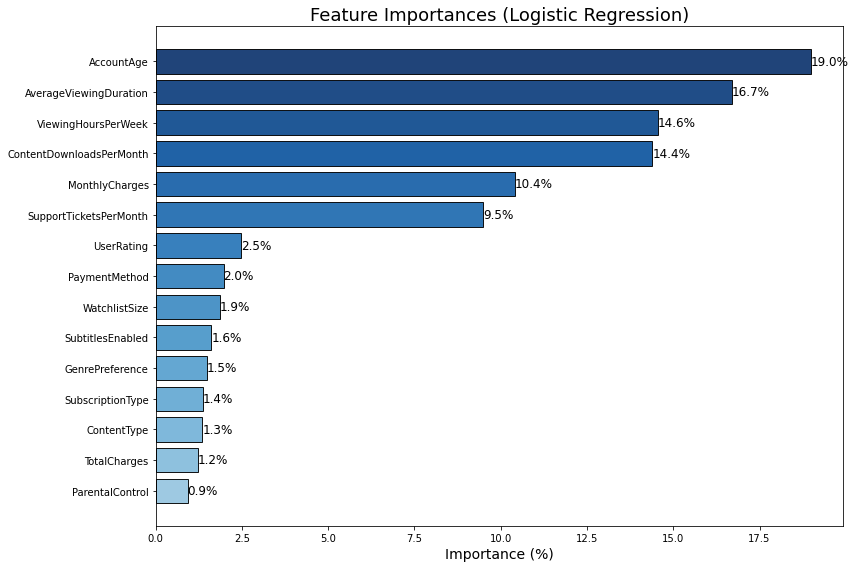

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importance for Logistic Regression
feature_importance = np.abs(log_reg.coef_[0])  # Absolute values of coefficients
feature_names = X.columns  # Feature names
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})

#  Convert importance values to percentages
importance_df["Importance (%)"] = (importance_df["Importance"] / importance_df["Importance"].sum()) * 100

#  Sort features by importance in descending order
importance_df = importance_df.sort_values(by="Importance (%)", ascending=False)

#  Plot top feature importances with color gradient
top_features = importance_df.head(15)
colors = plt.cm.Blues(np.linspace(1, 0.4, len(top_features)))

plt.figure(figsize=(12, 8))  # Increased the figure size
bars = plt.barh(
    top_features["Feature"],
    top_features["Importance (%)"],
    color=colors,
    edgecolor="black",
    alpha=0.9,
)

plt.gca().invert_yaxis()  # Highest importance at the top
plt.title("Feature Importances (Logistic Regression)", fontsize=18)
plt.xlabel("Importance (%)", fontsize=14)

# Add importance values on bars (rounded to 2 decimal places)
for bar, value in zip(bars, top_features["Importance (%)"]):
    plt.text(
        bar.get_width() + 0.001,  # Adjusted to provide more spacing
        bar.get_y() + bar.get_height() / 2,
        f"{value:.1f}%",  # Rounded to 2 decimal places
        va="center",
        fontsize=12,
    )

plt.tight_layout()
plt.show()

# Coefficients - Feature Importance Values

In [21]:
# Assuming 'log_reg' is your trained Logistic Regression model and 'X' is your feature DataFrame

# Extract coefficients
coefficients = log_reg.coef_[0]  # For binary classification, take the first row
absolute_coefficients = np.abs(coefficients)  # Use absolute values for importance ranking

# Pair coefficients with feature names
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": absolute_coefficients
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# (Optional) Convert to percentages
feature_importance_df["Importance (%)"] = (feature_importance_df["Importance"] / feature_importance_df["Importance"].sum()) * 100

# Display the DataFrame with feature importance values
print(feature_importance_df)


                     Feature  Importance  Importance (%)
0                 AccountAge    0.500480       18.982037
10    AverageViewingDuration    0.440410       16.703732
9        ViewingHoursPerWeek    0.383829       14.557740
11  ContentDownloadsPerMonth    0.379579       14.396533
1             MonthlyCharges    0.274406       10.407583
14    SupportTicketsPerMonth    0.250242        9.491083
13                UserRating    0.065123        2.469959
4              PaymentMethod    0.051874        1.967468
16             WatchlistSize    0.048953        1.856684
18          SubtitlesEnabled    0.042427        1.609149
12           GenrePreference    0.038965        1.477854
3           SubscriptionType    0.036211        1.373390
6                ContentType    0.035550        1.348316
2               TotalCharges    0.032168        1.220052
17           ParentalControl    0.024362        0.923984
15                    Gender    0.021162        0.802614
7          MultiDeviceAccess   

# Permutation Importance - Feature Importance Values

In [24]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, f1_score
import pandas as pd

# Calculate Permutation Importance on the validation set using F1 score
perm_importance = permutation_importance(
    log_reg,  # Trained logistic regression model
    X_val_scaled,  # Scaled validation features
    y_val,  # Validation target labels
    n_repeats=10,
    random_state=42,
    scoring=make_scorer(f1_score, average="binary")  # Using F1 score as the scoring metric
)

# Extract feature importances and feature names
feature_importances = perm_importance.importances_mean
feature_names = X.columns

# Convert importance values to percentages
total_importance = feature_importances.sum()
feature_importance_percentages = (feature_importances / total_importance) * 100

# Create a DataFrame to display feature importances
perm_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance (%)": feature_importance_percentages
}).sort_values(by="Importance (%)", ascending=False)

# Display the feature importance DataFrame
print("\nPermutation Importance for Features (as Percentage):")
print(perm_importance_df)

# Optionally save the results to an Excel file
output_file = r"permutation_importance_f1_score.xlsx"
perm_importance_df.to_excel(output_file, index=False)
print(f"\nPermutation importance percentages have been saved to: {output_file}")


Permutation Importance for Features (as Percentage):
                     Feature  Importance (%)
0                 AccountAge       24.792676
10    AverageViewingDuration       22.178993
9        ViewingHoursPerWeek       21.567990
11  ContentDownloadsPerMonth       20.112348
1             MonthlyCharges       17.386200
14    SupportTicketsPerMonth        6.950608
6                ContentType        0.469247
18          SubtitlesEnabled        0.191515
5           PaperlessBilling        0.149100
13                UserRating        0.039987
7          MultiDeviceAccess       -0.249083
8           DeviceRegistered       -0.347684
3           SubscriptionType       -0.598524
17           ParentalControl       -0.747450
16             WatchlistSize       -1.135470
15                    Gender       -1.725085
4              PaymentMethod       -2.073170
12           GenrePreference       -2.718323
2               TotalCharges       -4.243874

Permutation importance percentages have been 

# XGBClassifier

In [28]:
# Train an XGBClassifier model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, max_depth=3, n_estimators=100)

# Start time for training
start_time = time.time()

# Fit the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# End time for training
end_time = time.time()

# Make predictions on the validation set
y_val_pred = xgb_model.predict(X_val_scaled)
y_val_pred_prob = xgb_model.predict_proba(X_val_scaled)[:, 1]

# Evaluate performance on the validation set
val_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred),
    "Recall": recall_score(y_val, y_val_pred),
    "F1-Score": f1_score(y_val, y_val_pred),
    "Log Loss": log_loss(y_val, y_val_pred_prob),
    "Matthews Correlation Coefficient": matthews_corrcoef(y_val, y_val_pred),
    "ROC-AUC Score": roc_auc_score(y_val, y_val_pred_prob),
}

# Training time
train_time = end_time - start_time

# Print validation metrics
print("\nValidation Metrics for XGBClassifier:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

# Print training time
print("\nTraining Time: {:.2f} seconds".format(train_time))


Validation Metrics for XGBClassifier:
Accuracy: 0.8493
Precision: 0.5447
Recall: 0.0648
F1-Score: 0.1158
Log Loss: 0.3779
Matthews Correlation Coefficient: 0.1483
ROC-AUC Score: 0.7393

Training Time: 0.87 seconds


# Random Forest Classifier

In [32]:
# Train a Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Start time for training
start_time = time.time()

# Fit the model on the training data
rf_model.fit(X_train_scaled, y_train)

# End time for training
end_time = time.time()

# Make predictions on the validation set
y_val_pred = rf_model.predict(X_val_scaled)
y_val_pred_prob = rf_model.predict_proba(X_val_scaled)[:, 1]

# Evaluate performance on the validation set
val_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred),
    "Recall": recall_score(y_val, y_val_pred),
    "F1-Score": f1_score(y_val, y_val_pred),
    "Log Loss": log_loss(y_val, y_val_pred_prob),
    "Matthews Correlation Coefficient": matthews_corrcoef(y_val, y_val_pred),
    "ROC-AUC Score": roc_auc_score(y_val, y_val_pred_prob),
}

# Training time
train_time = end_time - start_time

# Print validation metrics
print("\nValidation Metrics for Random Forest Classifier:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

# Print training time
print("\nTraining Time: {:.2f} seconds".format(train_time))


Validation Metrics for Random Forest Classifier:
Accuracy: 0.8485
Precision: 0.5371
Recall: 0.0370
F1-Score: 0.0693
Log Loss: 0.3910
Matthews Correlation Coefficient: 0.1103
ROC-AUC Score: 0.7188

Training Time: 61.72 seconds


# LGBMClassifier

In [34]:
# Train an LGBMClassifier model
lgbm_model = LGBMClassifier(random_state=42, n_estimators=100)

# Start time for training
start_time = time.time()

# Fit the model on the training data
lgbm_model.fit(X_train_scaled, y_train)

# End time for training
end_time = time.time()

# Make predictions on the validation set
y_val_pred = lgbm_model.predict(X_val_scaled)
y_val_pred_prob = lgbm_model.predict_proba(X_val_scaled)[:, 1]

# Evaluate performance on the validation set
val_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred),
    "Recall": recall_score(y_val, y_val_pred),
    "F1-Score": f1_score(y_val, y_val_pred),
    "Log Loss": log_loss(y_val, y_val_pred_prob),
    "Matthews Correlation Coefficient": matthews_corrcoef(y_val, y_val_pred),
    "ROC-AUC Score": roc_auc_score(y_val, y_val_pred_prob),
}

# Training time
train_time = end_time - start_time

# Print validation metrics
print("\nValidation Metrics for LGBMClassifier:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

# Print training time
print("\nTraining Time: {:.2f} seconds".format(train_time))

[LightGBM] [Info] Number of positive: 22273, number of negative: 123977
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1498
[LightGBM] [Info] Number of data points in the train set: 146250, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.152294 -> initscore=-1.716721
[LightGBM] [Info] Start training from score -1.716721

Validation Metrics for LGBMClassifier:
Accuracy: 0.8492
Precision: 0.5466
Recall: 0.0568
F1-Score: 0.1030
Log Loss: 0.3774
Matthews Correlation Coefficient: 0.1392
ROC-AUC Score: 0.7407

Training Time: 2.00 seconds
